You can perform PID on MI(r;(x,v)), and compare the result of different 'x'.
'x' can from experimental data or produce in this code for different Tau (Gramma) or cutoff frequency
'r' can be real responses of RGC or form NGD.

# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
%matplotlib inline

In [2]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

In [3]:
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
    Information[('BROJA_2PID','SI')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIx')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIv')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','CI')]=np.zeros(len(bitshift))
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Information[('test','SI')]=np.zeros(len(bitshift))
    Information[('test','UIx')]=np.zeros(len(bitshift))
    Information[('test','UIv')]=np.zeros(len(bitshift))
    Information[('test','CI')]=np.zeros(len(bitshift))
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    parms = dict()
    parms['max_iters'] = 20
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
        Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt
                
#         PDF=Histo3D2Dict(pxvr)
#         BROJA_2PID = pid(PDF, cone_solver="ECOS", output=0, **parms)
#         Information[('BROJA_2PID','SI')][i]=BROJA_2PID['SI']/dt
#         Information[('BROJA_2PID','UIx')][i]=BROJA_2PID['UIY']/dt
#         Information[('BROJA_2PID','UIv')][i]=BROJA_2PID['UIZ']/dt
#         Information[('BROJA_2PID','CI')][i]=BROJA_2PID['CI']/dt
        

        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    return timeshift, Information

In [4]:
def Get_StimulusnResponse(ExporSim, conPar, par_list, IndParValue=1, channelnumber = 39):
    rstate_list = []
    if ExporSim=='Exp':
        x_list = []
        T_list = []
        if conPar=='Gramma':
            for G in par_list:
                exp_folder = 'D:\\GoogleDrive\\retina\\Exps\\2020\\0503'
                annots = loadmat(exp_folder+'\\merge\\'+'merge_0224_OUsmooth_RL_G'+str(G)+'_5min_Q100_6.5mW_1Hz.mat')
                x = np.squeeze(annots['bin_pos'])
                x = x.astype(float)
                x = (x-np.mean(x))/np.std(x)
                T = np.squeeze(annots['diode_BT'])
                rstate, _ = np.histogram(annots['reconstruct_spikes'][0][channelnumber-1], np.append(0,T))
                rstate_list.append(rstate.copy())
                x_list.append( x.copy())
                T_list.append( T.copy())
            dt = 1/60
        elif conPar=='Fc':
            for Fc in par_list:
                exp_folder = 'D:\\GoogleDrive\\retina\\Exps\\2020\\0729'
                annots = loadmat(exp_folder+'\\merge\\'+'merge_0727_OUsmooth_Bright_UL_DR_G4.5_5min_Q100_6.5mW_'+str(Fc)+'Hz.mat')
                x = np.squeeze(annots['bin_pos'])
                x = x.astype(float)
                x = (x-np.mean(x))/np.std(x)
                T = np.squeeze(annots['diode_BT'])
                rstate, _ = np.histogram(annots['reconstruct_spikes'][0][channelnumber-1], np.append(0,T))
                rstate_list.append(rstate.copy())
                x_list.append( x.copy())
                T_list.append( T.copy())
        dt = 1/60
    else:    ##'Sim':
        if conPar=='Tau':
            Tot=300
            dt=1./60
            T=np.arange(dt,Tot,dt)
            # OU ; input
            D = 27*10**5
            OU=np.zeros(len(T))
            mu, sigma = 0, 1
            cutoffFreq = IndParValue
            LPOU_list = []
            for tau in par_list:
                for i in range(len(T)-1):
                    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
                # filtering for OUSmoothed
                b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
                LPOU_list.append(signal.filtfilt(b, a, OU))
            x_list = LPOU_list.copy()  ##HMM or OU or LPOU
        elif conPar=='Fc':
            Tot=300
            dt=1./60
            T=np.arange(dt,Tot,dt)
            # OU ; input
            tau= IndParValue
            D = 27*10**5
            OU=np.zeros(len(T))
            mu, sigma = 0, 1
            for i in range(len(T)-1):
                OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
            # filtering for OUSmoothed
            LPOU_list = []
            for cutoffFreq in par_list:
                b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
                LPOU_list.append(signal.filtfilt(b, a, OU))
            x_list = LPOU_list.copy()  ##HMM or OU or LPOU
        T_list = [T]*len(par_list)
    return x_list, T_list, dt, rstate_list


# Main

In [5]:
Tau_list = [1.8,1.4,1,0.6,0.22]
x_list, T_list, dt, rstate_list = Get_StimulusnResponse('Exp', 'Gramma', [2.5,4.3,4.5,7.5,20],_, 21)
# x_list, T_list, dt, _ = Get_StimulusnResponse('Sim', 'Tau', Tau_list, 1)

In [6]:
v_list = []
for i in range(len(x_list)):
    v = ndimage.gaussian_filter1d(x_list[i].copy(), sigma=1, order=1, mode='wrap') / dt
    v_list.append(v[1:-1].copy())    
    x_list[i] = x_list[i][1:-1]
    T_list[i] = T_list[i][1:-1]
#     rstate_list[i] = rstate_list[i][1:-1]

In [7]:
#assign states
ystate_list = []
xstate_list = []
vstate_list = []
xvstate_list = []

for i in range(len(x_list)):
    xstate, _= EqualState(x_list[i], 6)
    vstate, _= EqualState(v_list[i], 6)
    xvstate = xstate*6+vstate
    xstate_list.append(xstate)
    vstate_list.append(vstate)
    xvstate_list.append(xvstate)

In [8]:
window = [-1,1] # second
xInformation_list = [0]*len(x_list)
vInformation_list = [0]*len(x_list)
xvInformation_list = [0]*len(x_list)
for i in range(len(x_list)):
    timeshift, xInformation_list[i] = PIfunc(xstate_list[i], xstate_list[i], vstate_list[i], dt, window)
    timeshift, vInformation_list[i] = PIfunc(vstate_list[i], xstate_list[i], vstate_list[i], dt, window)
    timeshift, xvInformation_list[i] = PIfunc(xvstate_list[i], xstate_list[i], vstate_list[i], dt, window)

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered i

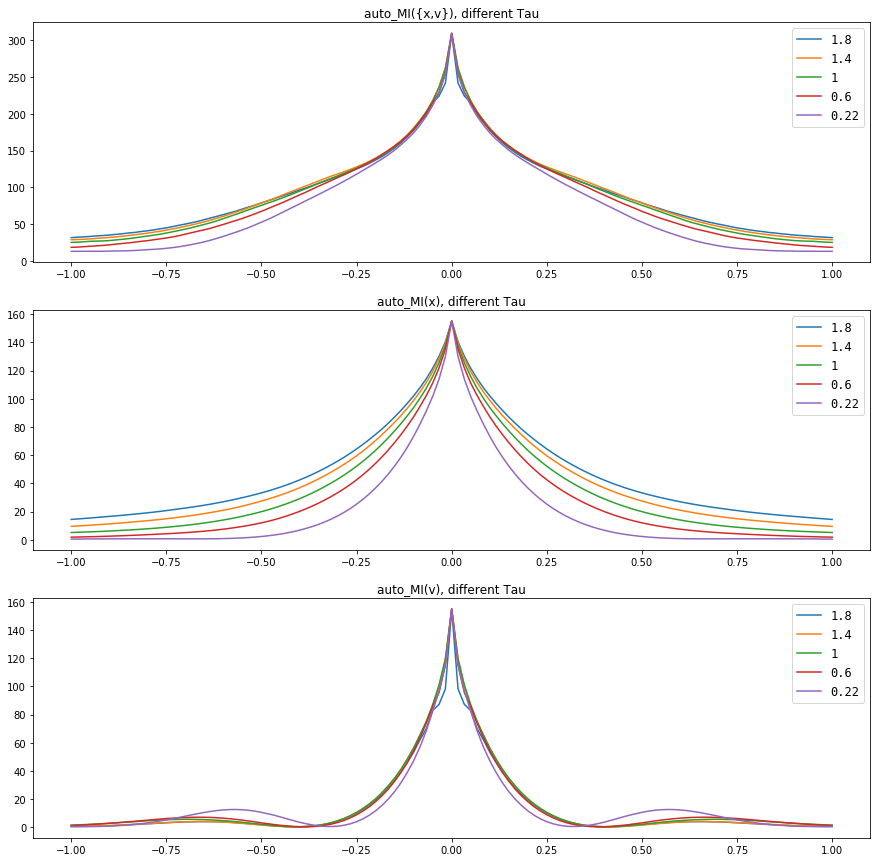

In [9]:
fig, (ax2, ax3, ax4) = plt.subplots(nrows=3, ncols=1) 
for i in range(len(x_list)):
    ax2.plot(timeshift,xvInformation_list[i][('Beer','UIx')]+xvInformation_list[i][('Beer','Red')]+xvInformation_list[i][('Beer','UIv')]+xvInformation_list[i][('Beer','Syn')])
    ax3.plot(timeshift,xInformation_list[i][('Beer','UIx')]+xInformation_list[i][('Beer','Red')])
    ax4.plot(timeshift,vInformation_list[i][('Beer','UIv')]+vInformation_list[i][('Beer','Red')])
ax2.legend( Tau_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( Tau_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax4.legend( Tau_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.set_title('auto_MI({x,v}), different Tau')
ax3.set_title('auto_MI(x), different Tau')
ax4.set_title('auto_MI(v), different Tau')
fig = plt.gcf()
fig.set_size_inches(15, 15)

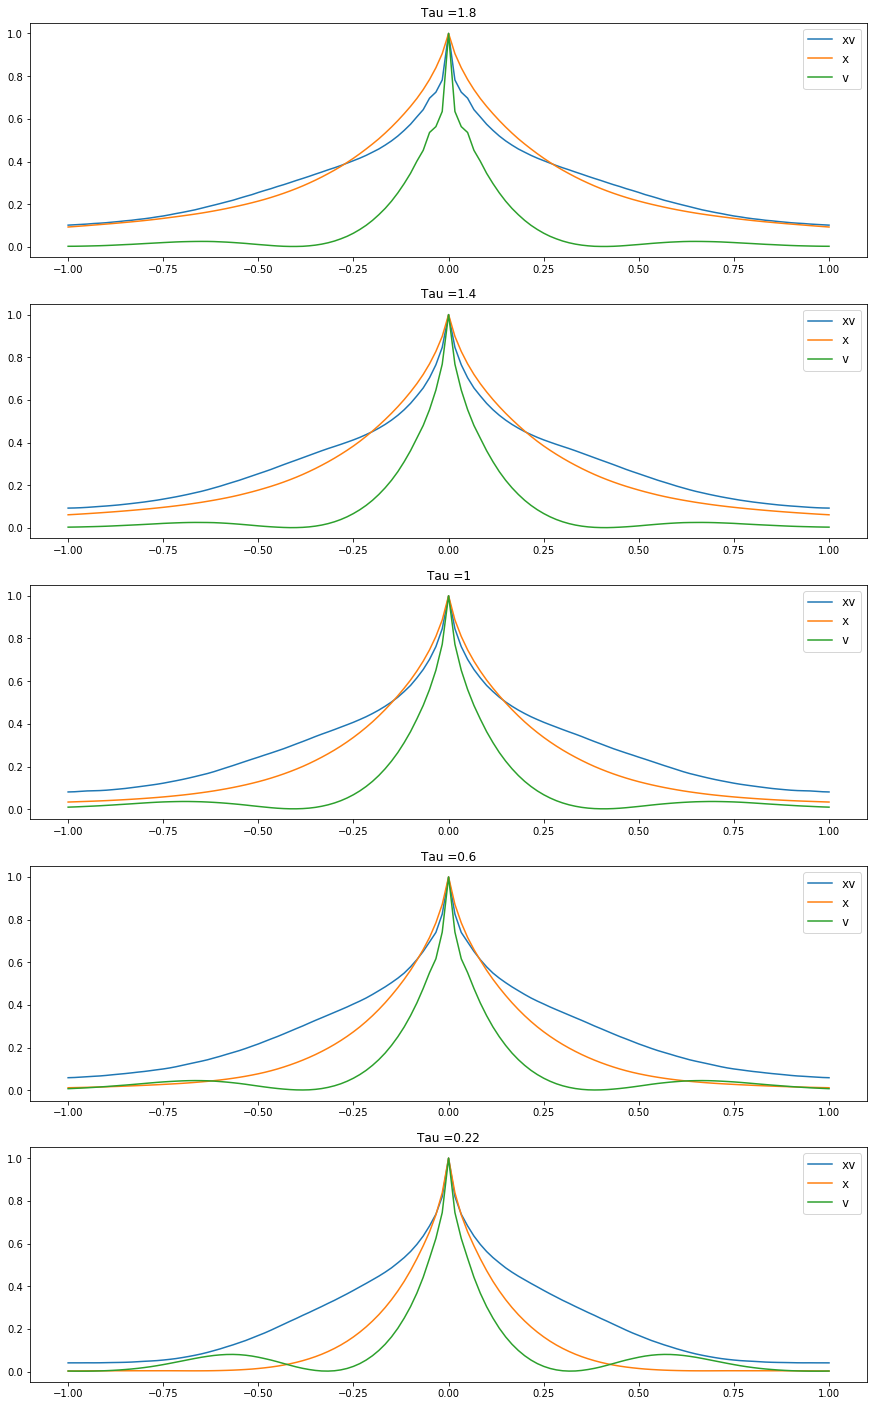

In [10]:
legend_list = []
fig, ax = plt.subplots(nrows=len(x_list), ncols=1) 
for i in range(len(x_list)):
    maxMIxv = max(xvInformation_list[i][('Beer','UIx')]+xvInformation_list[i][('Beer','Red')]+xvInformation_list[i][('Beer','UIv')]+xvInformation_list[i][('Beer','Syn')])
    maxMIx = max( xInformation_list[i][('Beer','UIx')]+xInformation_list[i][('Beer','Red')])
    maxMIv = max( vInformation_list[i][('Beer','UIv')]+vInformation_list[i][('Beer','Red')])
    ax[i].plot(timeshift,(xvInformation_list[i][('Beer','UIx')]+xvInformation_list[i][('Beer','Red')]+xvInformation_list[i][('Beer','UIv')]+xvInformation_list[i][('Beer','Syn')])/maxMIxv)
    ax[i].plot(timeshift,(xInformation_list[i][('Beer','UIx')]+xInformation_list[i][('Beer','Red')])/maxMIx)
    ax[i].plot(timeshift,(vInformation_list[i][('Beer','UIv')]+vInformation_list[i][('Beer','Red')])/maxMIv)
    ax[i].legend( ['xv', 'x' ,'v'], loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax[i].set_title('Tau ='+str(Tau_list[i]))
fig = plt.gcf()
fig.set_size_inches(15, 25)

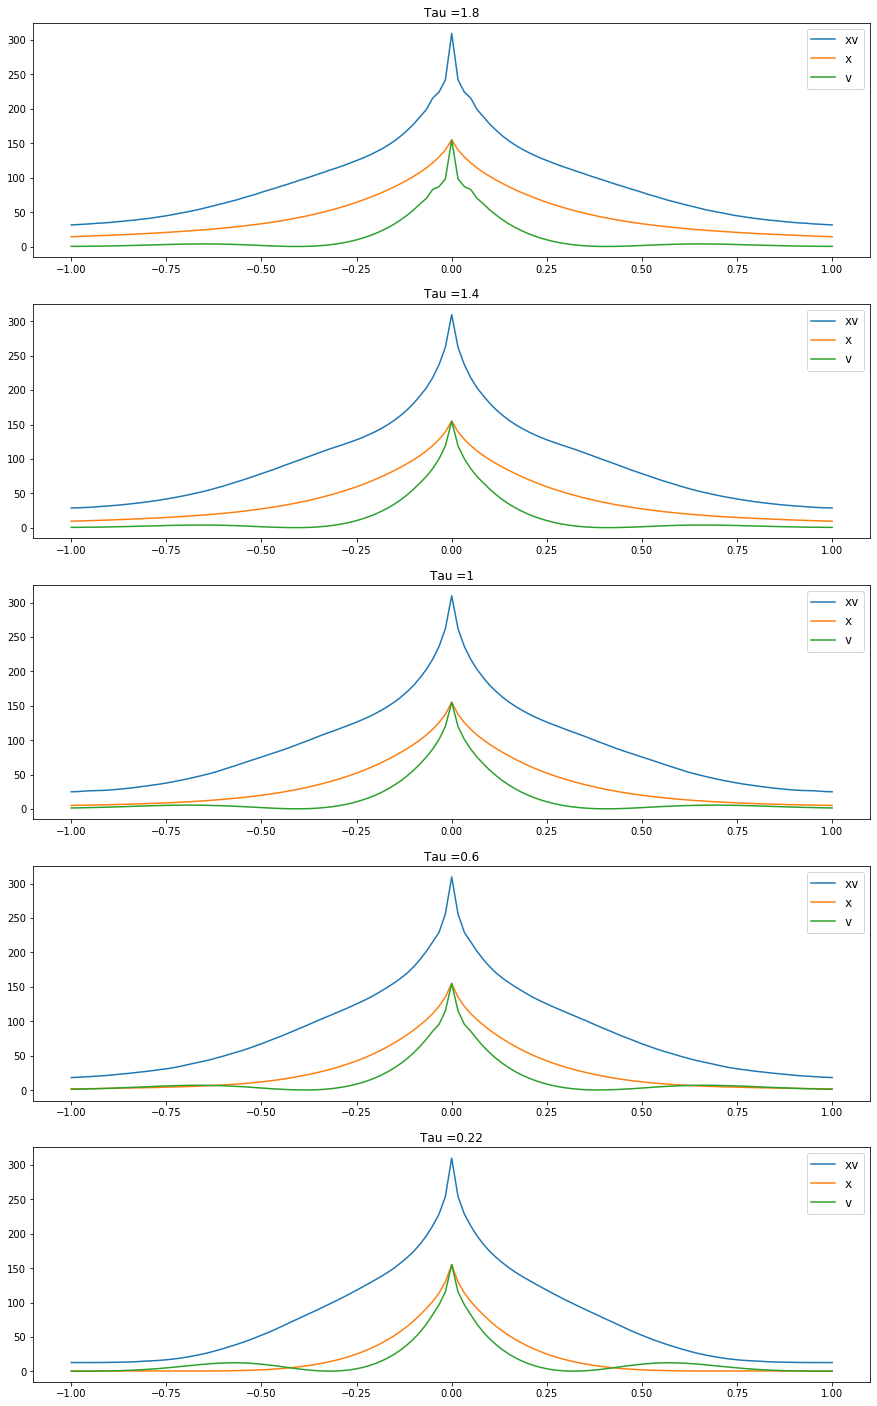

In [11]:
legend_list = []
fig, ax = plt.subplots(nrows=len(x_list), ncols=1) 
for i in range(len(x_list)):
    ax[i].plot(timeshift,(xvInformation_list[i][('Beer','UIx')]+xvInformation_list[i][('Beer','Red')]+xvInformation_list[i][('Beer','UIv')]+xvInformation_list[i][('Beer','Syn')]))
    ax[i].plot(timeshift,(xInformation_list[i][('Beer','UIx')]+xInformation_list[i][('Beer','Red')]))
    ax[i].plot(timeshift,(vInformation_list[i][('Beer','UIv')]+vInformation_list[i][('Beer','Red')]))
    ax[i].legend( ['xv', 'x' ,'v'], loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax[i].set_title('Tau ='+str(Tau_list[i]))
fig = plt.gcf()
fig.set_size_inches(15, 25)